# Performance Measures II


In this notebook, we will learn about visual performance measures like ROC curves and Lift Charts and information theory based performance measure KL Divergence.

### **Table of Contents**
1. [ROC Analysis](#roc_analysis)
2. [Lift Charts](#lift_charts)
3. [KL Divergence](#kl_divergence)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

### **1.Receiver Operating Characteristic (ROC) Analysis** <a class="anchor" id="roc_analysis"></a>

In this section, we implement ROC curve.

The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classification model. It illustrates the trade-off between the true positive rate (TPR) and the false positive rate (FPR) at various classification thresholds.

The ROC curve is created by plotting the TPR against the FPR as the classification threshold changes. Each point on the curve represents a different threshold setting. The closer the curve is to the top-left corner, the better the model's performance, as it indicates higher TPR and lower FPR.

To generate an ROC curve, typically we follow these steps:

1. Train a binary classification model on a labeled dataset.
2. Obtain the predicted probabilities or scores for each instance in the dataset.
3. Vary the classification threshold from 0 to 1.
4. For each threshold, calculate the corresponding TPR and FPR based on the predicted probabilities and true labels.
5. Plot the obtained TPR-FPR pairs to create the ROC curve.


Given below is a simple, but rather inefficient algorithm for computing ROC-curves. 
The implementation below assumes that ``labels`` is a contain the (numerical) true class label and ``scores`` contain the assigned scores from the classifier (each for the respective instance), while `l` is the class we consider to be the positive one.



In [2]:
def roc_curve_inefficient( labels, l, scores ):
    # l = positive class
    score_min, score_max = min(scores), max(scores)
    zs = sorted(scores)
    incr = min( [ y1-y2 for y1, y2 in zip(zs[1:], zs[:-1])] )
    zs = np.array(zs)
    
    T = len(labels) # Anzahl Datenpunkte
    P = sum([1 for a in labels if a == l]) # Anzahl positive Datenpunkte
    N = T-P # Anzahl negative Datenpunkte
    
    out=[]
    if incr != 0:   # step size == 0
        for t in list(np.arange(score_min, score_max+incr, incr)):  # threshold t
            fp, tp = 0, 0
            for i in range(len(labels)):    # iterate over all data points inefficiently -> matrix operation
                if scores[i] >= t:
                    if labels[i] == l:  # true positive
                        tp += 1
                    else:            # false positive
                        fp += 1
            out.append((fp/N, tp/P))    # (FPR, TPR)
    else:
        for t in zs:
            #t = zs[0]   # neiedrigster score als threshold
            fp, tp = 0, 0
            for i in range(len(labels)):
                if scores[i] >= t:
                    if labels[i] == l:
                        tp += 1
                    else:
                        fp += 1
            out.append((fp/N, tp/P))
    
    return np.unique(np.array(out), axis=0)

#### Question:
1. (a) Why is the above function inefficient? Implement an efficient alternative function (roc_curve) to generate roc curve.

iterate over all data points inefficiently -> matrix operation
incrementing the threshold by a fixed step size
statt if clauase, incr = max(incr, 0.01)


We implement the function [`roc_curve`](../e2ml/evaluation/_performance_measures_II.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage.
Once, the implementation has been completed, we check its validity for simple example. 

[[0.  0. ]
 [0.  0. ]
 [0.  0.2]
 [0.  0.4]
 [0.2 0.4]
 [0.2 0.6]
 [0.4 0.6]
 [0.4 0.8]
 [0.6 0.8]
 [0.8 0.8]
 [0.8 1. ]
 [1.  1. ]]


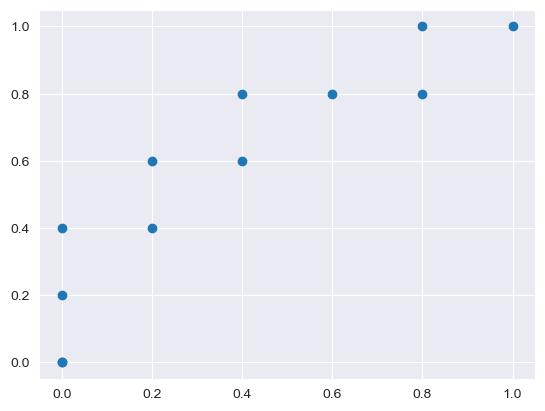

In [20]:
from e2ml.evaluation import roc_curve
# Test correct computation for various simple examples.

# Example
labels = [0, 1, 0, 1, 1, 0, 1, 0, 1, 0]
x = 1
scores = [0.85, 0.65, 0.64, 0.5, 0.45, 0.95, 0.9, 0.8, 0.68, 0.66]
roc_curve_result = roc_curve(labels, x, scores)
print(roc_curve_result)
plt.scatter(roc_curve_result[:,0], roc_curve_result[:,1])

1. (b) Now we visualize the curve generated by the previously defined inefficient function and new efficient function to compare.

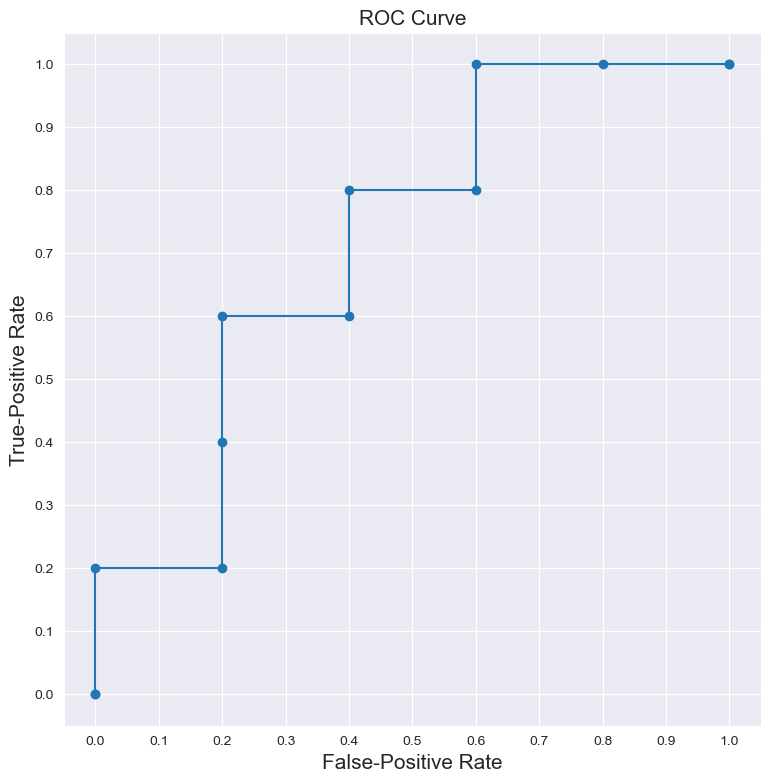

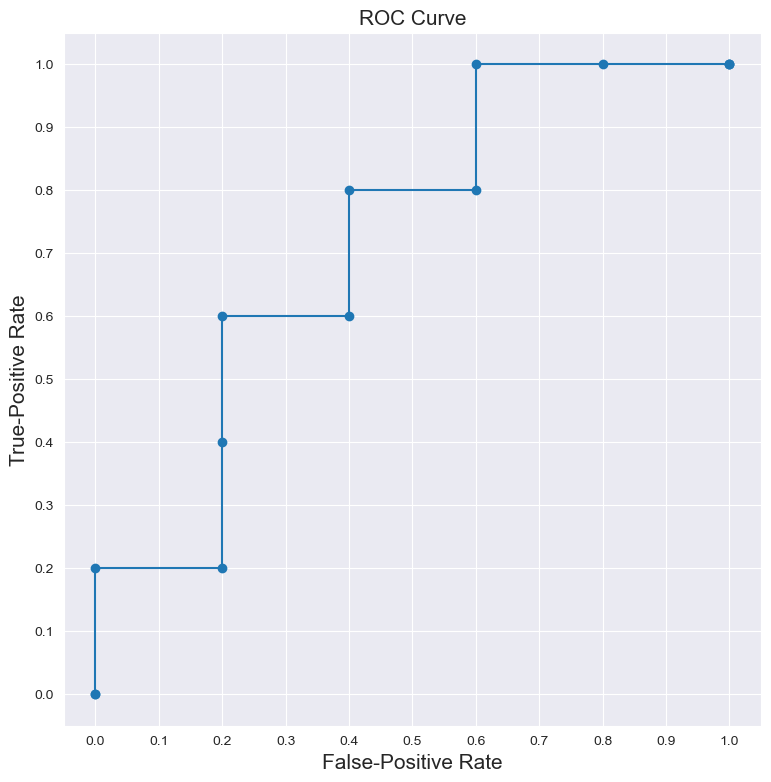

In [21]:
def draw_roc_curve(points):
    tmp = np.vstack(([[0,0]], points[np.lexsort(points.T)], [[1,1]]))
    plt.figure(figsize=(9, 9))
    
    plt.scatter(tmp[:,0], tmp[:,1])
    plt.plot(tmp[:,0], tmp[:,1])
    
    plt.xlabel('False-Positive Rate', fontsize=15)
    plt.xticks(np.linspace(0,1,11))
    plt.ylabel('True-Positive Rate', fontsize=15)
    plt.yticks(np.linspace(0,1,11))
    plt.title('ROC Curve', fontsize=15)
    plt.show()

# Using the example from the book:
labelsExample = np.array([   0,    1,    0,   1,    1,    0,   1,   0,    1,    0])
scoresExample = np.array([0.85, 0.65, 0.64, 0.5, 0.45, 0.95, 0.9, 0.8, 0.68, 0.66])
draw_roc_curve(roc_curve_inefficient(labelsExample, 0, scoresExample))
draw_roc_curve(roc_curve(labelsExample, 0, scoresExample))

1. (c) Implement a function that computes the Are Under Curve (AUC) using the values returned by the ROC Curve. 

    The area under the ROC curve (AUC) is a commonly used metric to evaluate the overall performance of a classification model. A perfect classifier has an AUC of 1, while a random or poor classifier has an AUC close to 0. The AUC provides a single value that summarizes the model's performance across all possible classification thresholds.

    AUC is the area of the polygon defined by the points returned by [`roc_curve`](../e2ml/evaluation/_performance_measures_II.py) together with the point $(0,0)$, $(1,0)$ and $(1,1)$.
    -> wie gut ist classifier ungeachtet des thresholds

We implement the function [`roc_auc`](../e2ml/evaluation/_performance_measures_II.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage.
Once, the implementation has been completed, we check its validity for the points of the ROC curve visualized before. 

In [23]:
from e2ml.evaluation import roc_auc
points = [(0.0, 0.0), (0.0, 0.2), (0.2, 0.2),  (0.2, 0.4), (0.2, 0.6), (0.4, 0.6), (0.4, 0.8), (0.6, 0.8), (0.6, 1.0), (0.8,1.0),(1.0, 1.0)]
auc = roc_auc(points)
print(auc)

0.72


### **2. Lift Charts** <a class="anchor" id="lift_charts"></a>

In this section, we learn to generate Lift charts.

Lift charts follow a similar idea to ROC curves. However, instead of plotting the True-Positive against the False-Positive Rate, Lift Charts plot the actual number of true-positives against the number of samples.

We implement the function [`draw_lift_chart`](../e2ml/evaluation/_performance_measures_II.py) from lists of the true class labels and the predicted labels in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage.
Once, the implementation has been completed, we check its validity with a simple example. We again assume the class labels to be numerical, with ``pos`` being the class which is considered as positive one.

Optimal: Diagonale links unten nach rechts oben
Area Diagonale und Punkte ist Maß für Güte des Classifiers

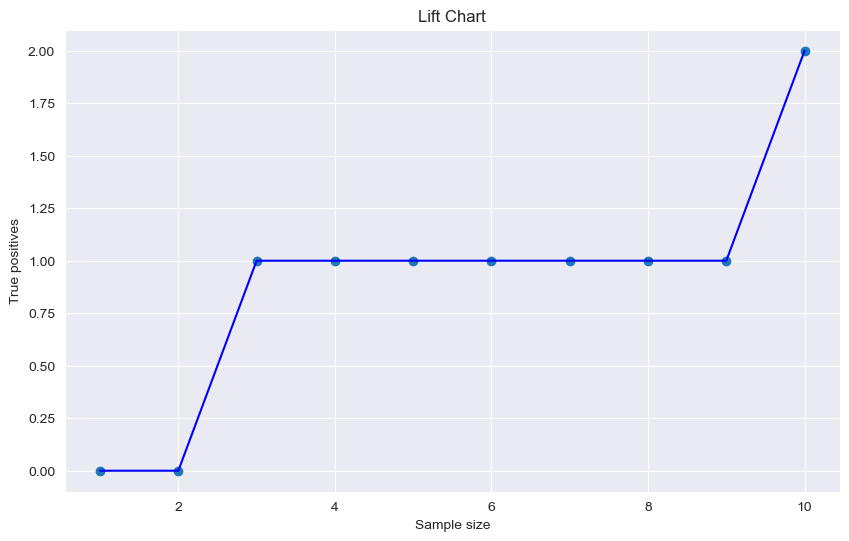

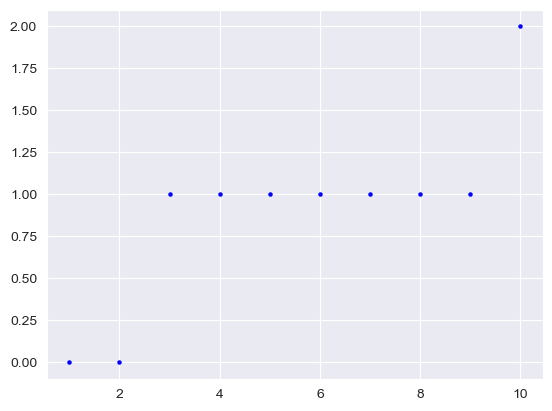

In [33]:
from e2ml.evaluation import draw_lift_chart

predictedExample = np.zeros(labelsExample.shape)
predictedExample[scoresExample >= 0.8] = 1    
draw_lift_chart(labelsExample, 0, predictedExample)

### **3. Kullback-Leibler (KL) Divergence** <a class="anchor" id="kl_divergence"></a>

KL divergence, short for Kullback-Leibler divergence, is a measure of the difference between two probability distributions. It quantifies how one distribution differs from a second, reference distribution. KL divergence is asymmetric and non-negative, meaning that it is not a true distance metric.

The KL divergence between two probability distributions P and Q is defined as:

\begin{equation*}
    KL(P || Q) = \sum{P(x) \cdot \log{\left(\frac{P(x)}{Q(x)}\right)}}
\end{equation*}

where $P(x)$ and $Q(x)$ are the probability mass or density functions of distributions $P$ and $Q$ respectively.

We now implement the function [`kl_divergence`](../e2ml/evaluation/_performance_measures_II.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage.
Once, the implementation has been completed, we check its validity with a simple example.

Unterschied zwischen distributions P und Q.
Wie gut Verteilung Q die Verteilung P approximiert/abbildet.
Da P(x) gewichtet an der Summe,fallen Summanden mit großen P(x) stärker ins Gewicht.


In [27]:
from e2ml.evaluation import kl_divergence
# Example 
p = np.array([0.2, 0.3, 0.5])
q = np.array([0.25, 0.25, 0.5])

kl_div = kl_divergence(p, q)
print("KL divergence:", kl_div) # 0 falls gleich, klein ist gut
print("KL divergence:", kl_divergence(p,p))

KL divergence: 0.010067756775344432
KL divergence: 0.0
